In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#### Criamos três conjuntos de dados sintéticos: um para dados antigos, um para dados recentes e outro para dados futuros. Este último será nosso conjunto de validação.

In [3]:
n_samples, n_features = 10000, 3
seed = 0
rng = np.random.RandomState(seed)

X, y = make_regression(n_samples, n_features, random_state=rng, noise=.1, n_informative=3)

In [4]:
df_antigo = pd.DataFrame(X).add_prefix('Feature_')
features = list(df_antigo.columns)
df_antigo['Target'] = y

df_recente = df_antigo.copy()

# As features 0 e 2 terão seu comportamento mantido.
df_recente[['Feature_0', 'Feature_2']] = df_recente[['Feature_0', 'Feature_2']] + np.random.rand(len(df_recente), 2)

# A feature 1 e o target serão propositalmente modificados para a criação do shift.
df_recente['Feature_1'] =  df_recente['Feature_1'] + 5 * np.random.rand(len(df_recente), 1).flatten()
df_recente['Target'] = -0.5 * df_antigo['Target']

# O conjunto de dados futuro é similar ao recente.
df_futuro = df_recente.copy()
df_futuro = df_futuro + np.random.rand(len(df_futuro), len(df_futuro.columns))

#### É possível visualizar como a Feature_1 e o Target alteraram o comportamento.

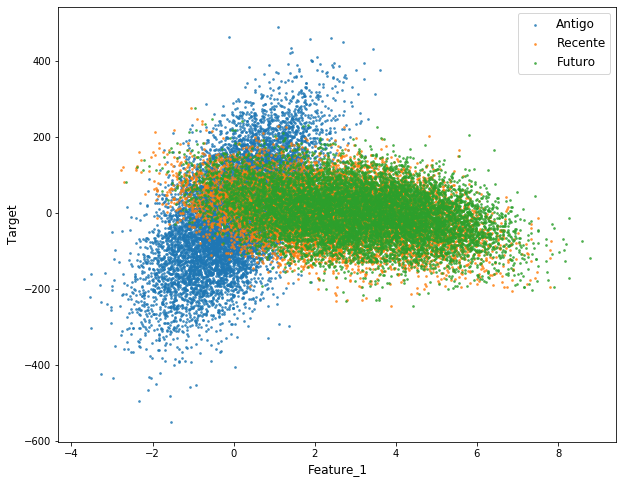

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.scatter(df_antigo['Feature_1'], df_antigo['Target'], s=3, alpha=.7, label='Antigo')
plt.scatter(df_recente['Feature_1'], df_recente['Target'], s=3, alpha=.7, label='Recente')
plt.scatter(df_futuro['Feature_1'], df_futuro['Target'], s=3, alpha=.7, label='Futuro')

plt.xlabel('Feature_1')
plt.ylabel('Target')
plt.legend(loc='upper right', prop={'size': 12})
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.show()

#### Na sequência, procedemos com a tarefa original de regressão. São treinados dois modelos: um apenas com dados antigos e outro com os dados antigos e os recentes. 

#### A ideia aqui é simular dois cenários: o primeiro, em que o modelo é treinado apenas uma vez (e mantido assim em produção) e outro cenário em que o modelo é retreinado na medida em que novos dados são disponibilizados.

#### A performance de ambos modelos é atestada no conjunto de dados futuros. É possível observar que há ganhos em considerar uma base maior para a modelagem.

In [6]:
reg_antigo = LinearRegression().fit(df_antigo[features], df_antigo['Target'])

df = pd.concat([df_antigo, df_recente]).reset_index(drop=True)
reg_base_maior = LinearRegression().fit(df[features], df['Target'])

In [7]:
print(mean_absolute_error(df_futuro['Target'], reg_antigo.predict(df_futuro[features])))
print(mean_absolute_error(df_futuro['Target'], reg_base_maior.predict(df_futuro[features])))

397.64469885180057
73.29393758246066


####  Visualmente, é possível ver que mesmo com o aumento da base, ainda há contaminação dos dados mais antigos, inserindo um viés na predição.

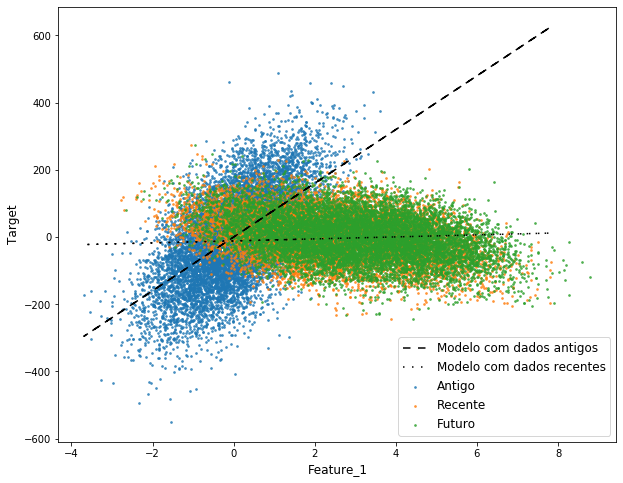

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.scatter(np.array(df_antigo['Feature_1']), np.array(df_antigo['Target']), s=3, alpha=.7, label='Antigo')
plt.scatter(np.array(df_recente['Feature_1']), np.array(df_recente['Target']), s=3, alpha=.7, label='Recente')
plt.scatter(np.array(df_futuro['Feature_1']), np.array(df_recente['Target']), s=3, alpha=.7, label='Futuro')

plt.plot(np.array(df['Feature_1']), np.array(df['Feature_1'] * reg_antigo.coef_[1] + reg_antigo.intercept_), c='0', ls='--', dashes=(5, 5), label='Modelo com dados antigos')
plt.plot(np.array(df['Feature_1']), np.array(df['Feature_1'] * reg_base_maior.coef_[1] + reg_base_maior.intercept_), c='0', ls=':', dashes=(1, 5), label='Modelo com dados recentes')

plt.xlabel('Feature_1')
plt.ylabel('Target')
plt.legend(loc='lower right', prop={'size': 12})
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.show()

#### Agora que temos nosso problema posto, podemos avançar com a aplicação da técnica de Adversarial Validation.

In [9]:
# Os rótulos adicionais são criados e novos conjuntos de treino e teste são criados para a classificação.

df['Target_Adversarial_Validation'] = np.nan
df.loc[0:(len(df_antigo)-1), 'Target_Adversarial_Validation'] = 0
df.loc[(len(df_recente)-1):, 'Target_Adversarial_Validation'] = 1

X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df['Target_Adversarial_Validation'], 
                                                    test_size=0.5, 
                                                    random_state=seed, 
                                                    stratify=df['Target_Adversarial_Validation'])

#### Os dados são normalizados, o classificador é treinado e avaliado. É possível detectar a presença de shift.

#### Na sequência, avaliamos os coeficientes do modelo logístico e vemos o comportamento esperado: a feature que mais contribui para o shift é a Feature_1.

In [10]:
scaler = StandardScaler() # A normalização favorece a interpretação dos coeficientes.
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

adversarial_clf = LogisticRegression(random_state=seed).fit(X_train, y_train)
y_pred = adversarial_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9067116

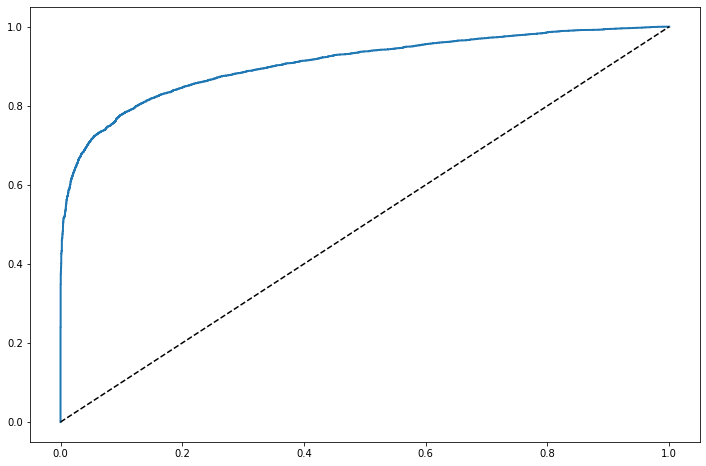

In [11]:
def plot_roc_curve(fpr, tpr, label=None):
    fig = plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
plot_roc_curve(fpr_test, tpr_test)

<BarContainer object of 3 artists>

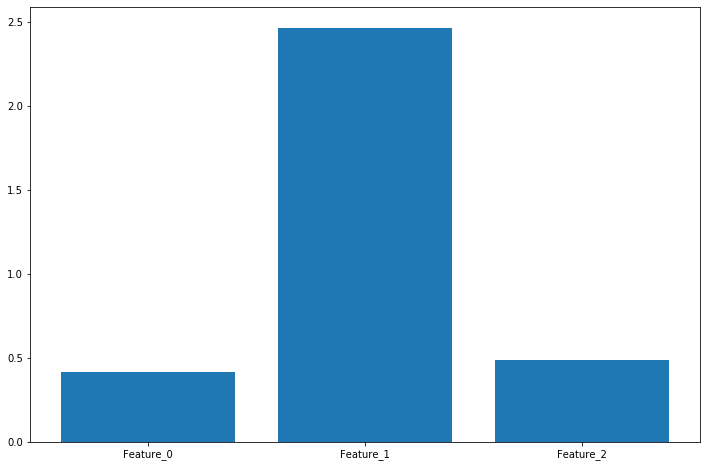

In [12]:
fig = plt.figure(figsize=(12, 8))
plt.bar(list(X_train.columns), list(adversarial_clf.coef_[0]))

#### Após diagnosticarmos o shift, podemos retornar à tarefa original de regressão. 

#### Para esse caso específico, optamos por retreinar a regressão mantendo observações em que o classificador possui uma certeza relevante de que são dos dados mais recentes ou observações que sabidamente são desse período. 

#### A redução do erro médio absoluto é notável, assim como a diminuição do viés do modelo.

In [13]:
df['Predição_Classificador'] = adversarial_clf.predict_proba(df[X_test.columns])[:, 1]

limiar = .8
df_retreino_reg = df[((df['Predição_Classificador'] >= limiar) & (df['Target_Adversarial_Validation'] == 0)) | (df['Target_Adversarial_Validation'] == 1)].copy()
reg_atualizado = LinearRegression().fit(df_retreino_reg[features], df_retreino_reg['Target'])

print(mean_absolute_error(df_futuro['Target'], reg_atualizado.predict(df_futuro[features])))

38.980466772995946


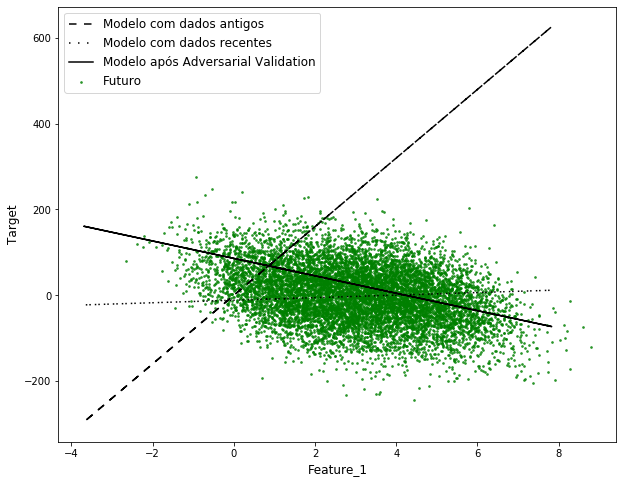

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.scatter(df_futuro['Feature_1'], df_recente['Target'], s=3, alpha=.7, label='Futuro', c='g')

plt.plot(np.array(df['Feature_1']), np.array(df['Feature_1'] * reg_antigo.coef_[1] + reg_antigo.intercept_), c='0', ls='--', dashes=(5, 5), label='Modelo com dados antigos')
plt.plot(np.array(df['Feature_1']), np.array(df['Feature_1'] * reg_base_maior.coef_[1] + reg_base_maior.intercept_), c='0', ls=':', dashes=(1, 5), label='Modelo com dados recentes')
plt.plot(np.array(df['Feature_1']), np.array(df['Feature_1'] * reg_atualizado.coef_[1] + reg_atualizado.intercept_), c='0', ls='-', label='Modelo após Adversarial Validation')

plt.xlabel('Feature_1')
plt.ylabel('Target')
plt.legend(loc='upper left', prop={'size': 12})
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.show()